# Simulating Dopamine Reward Encoding
## Comparing the performance of feed-forward and recurrent neural networks
## with motivation from Dopamine literature

## Table of contents:
### - Imports
### - Lasagne (neural net library) starter/example code, from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py
### - Network Analysis Helper Code, to build Hinton diagrams and Saliency Maps (taken from the internet, not original code
## - Data and Neural Network Definitions - defines the dataset and models -  ORIGINAL CODE!
### - Run the Neural Networks - defines a function to train the nets - modified Lasagne starter code
## - Model Evaluation - runs, evaluates, and graphs the results of the models - ORIGINAL!

In [5]:
"""
Usage example employing Lasagne for digit recognition using the MNIST dataset.
This example is deliberately structured as a long flat file, focusing on how
to use Lasagne, instead of focusing on writing maximally modular and reusable
code. It is used as the foundation for the introductory Lasagne tutorial:
http://lasagne.readthedocs.org/en/latest/user/tutorial.html
More in-depth examples and reproductions of paper results are maintained in
a separate repository: https://github.com/Lasagne/Recipes
"""

from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
from theano import pp, printing
import theano.tensor as T

import lasagne

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Lasagne Starter/Example Code
### This code is not original work! But it did provide the basis for much of my code.

In [6]:
# ################## Download and prepare the MNIST dataset ##################
# This is just some way of getting the MNIST dataset from an online location
# and loading it into numpy arrays. It doesn't involve Lasagne at all.

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


# ##################### Build the neural network model #######################
# This script supports three types of models. For each one, we define a
# function that takes a Theano variable representing the input and returns
# the output layer of a neural network model built in Lasagne.

def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 10 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # We'll now add dropout of 50%:
    #l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    #l_hid2 = lasagne.layers.DenseLayer(
    #        l_hid1_drop, num_units=800,
    #        nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    #l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    l_out = lasagne.layers.DenseLayer(
            l_hid1, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out


def build_custom_mlp(input_var=None, depth=2, width=800, drop_input=.2,
                     drop_hidden=.5):
    # By default, this creates the same network as `build_mlp`, but it can be
    # customized with respect to the number and size of hidden layers. This
    # mostly showcases how creating a network in Python code can be a lot more
    # flexible than a configuration file. Note that to make the code easier,
    # all the layers are just called `network` -- there is no need to give them
    # different names if all we return is the last one we created anyway; we
    # just used different names above for clarity.

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.rectify
    for _ in range(depth):
        network = lasagne.layers.DenseLayer(
                network, width, nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(network, 10, nonlinearity=softmax)
    return network


def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network


# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.
# Notice that this function returns only mini-batches of size `batchsize`.
# If the size of the data is not a multiple of `batchsize`, it will not
# return the last (remaining) mini-batch.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [7]:
# ############################## Main program ################################
# Everything else will be handled in our main program now. We could pull out
# more functions to better separate the code, but it wouldn't make it any
# easier to read.

def main(model='mlp', num_epochs=500):
    # Load the dataset
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    if model == 'mlp':
        network = build_mlp(input_var)
    elif model.startswith('custom_mlp:'):
        depth, width, drop_in, drop_hid = model.split(':', 1)[1].split(',')
        network = build_custom_mlp(input_var, int(depth), int(width),
                                   float(drop_in), float(drop_hid))
    elif model == 'cnn':
        network = build_cnn(input_var)
    else:
        print("Unrecognized model type %r." % model)
        return

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))



    # Optionally, you could now dump the network weights to a file like this:
    # np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)


if __name__ == '__main__':
    if ('--help' in sys.argv) or ('-h' in sys.argv):
        print("Trains a neural network on MNIST using Lasagne.")
        print("Usage: %s [MODEL [EPOCHS]]" % sys.argv[0])
        print()
        print("MODEL: 'mlp' for a simple Multi-Layer Perceptron (MLP),")
        print("       'custom_mlp:DEPTH,WIDTH,DROP_IN,DROP_HID' for an MLP")
        print("       with DEPTH hidden layers of WIDTH units, DROP_IN")
        print("       input dropout and DROP_HID hidden dropout,")
        print("       'cnn' for a simple Convolutional Neural Network (CNN).")
        print("EPOCHS: number of training epochs to perform (default: 500)")
    else:
        kwargs = {}
        #print (str(sys.argv))
        #if len(sys.argv) > 1:
        #    kwargs['model'] = sys.argv[1]
        #if len(sys.argv) > 2:
        #    kwargs['num_epochs'] = int(sys.argv[2])
main('mlp', 2)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 2 took 7.665s
  training loss:		0.927675
  validation loss:		0.401598
  validation accuracy:		89.63 %
Epoch 2 of 2 took 6.845s
  training loss:		0.431612
  validation loss:		0.321163
  validation accuracy:		91.17 %
Final results:
  test loss:			0.329578
  test accuracy:		90.91 %


In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [9]:
#printing.debugprint(lasagne.utils.one_hot([1,2,3], m=None))
#lasagne.layers.get_output(lasagne.utils.one_hot([1,2,3], m=15), deterministic=True)
num_inp = 1000
t = np.zeros((num_inp,1,1,15))
for i in range(num_inp):
    t[i,0,0,np.random.randint(0,15)] = 1
    
y_train.shape

(50000,)

## Network Analysis Helper Code

In [10]:
def compile_saliency_function(net,inpu):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    inp = inpu
    outp = lasagne.layers.get_output(net, deterministic=True)
    max_outp = T.max(outp, axis=1)
    saliency = theano.grad(max_outp.sum(), wrt=inp)
    max_class = T.argmax(outp, axis=1)
    return theano.function([inp], [saliency, max_class])



def show_images(img_original, saliency, max_class, title):
    # get out the first map and class from the mini-batch
    #saliency = saliency[0]
    #max_class = max_class[0]
    # convert saliency from BGR to RGB, and from c01 to 01c
    #saliency = saliency[::-1].transpose(1, 2, 0)
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(1, 15), facecolor='w')
    #plt.suptitle("Class: " + max_class + ". Saliency: " + title)
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(img_original)
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.show()
    
def _blob(x, y, area, colour):
    """
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
    ycorners = np.array([y - hs, y - hs, y + hs, y + hs])
    plt.fill(xcorners, ycorners, colour, edgecolor=colour)

def hinton(W, names=None, maxweight=None, filename=None):
# def hinton(W, maxweight=None):
    """
    Draws a Hinton diagram for visualizing a weight matrix. 
    Temporarily disables matplotlib interactive mode if it is on, 
    otherwise this takes forever.
    """


    # F = plt.gcf()
    # F.set_dpi( 300 )
    # print "DPI", F.get_dpi()

    F = plt.figure(num=None, figsize=(8,6), dpi=300, facecolor='w', edgecolor='k')

    reenable = False
    if plt.isinteractive():
        plt.ioff()
    
    F.clf()
    height, width = W.shape
    if not maxweight:
        maxweight = 2**np.ceil(np.log(np.max(np.abs(W)))/np.log(2))
        print ("Max weight: "  + str(maxweight))
        
    plt.fill(np.array([0, width, width, 0]),
             np.array([0, 0, height, height]),
             'gray')
    
    plt.axis('off')
    plt.axis('equal')
    for x in xrange(width):
        if names:
            plt.text(-0.5, x, names[x], fontsize=4, ha='right', va='bottom')
            plt.text(x, height+0.5, names[height-x-1], fontsize=4, va='bottom', rotation='vertical', ha='left')
        for y in xrange(height):
            _x = x+1
            _y = y+1
            w = W[y, x]
            if w > 0:
                _blob(_x - 0.5,
                      height - _y + 0.5,
                      min(1, w/maxweight),
                      'white')
            elif w < 0:
                _blob(_x - 0.5,
                      height - _y + 0.5, 
                      min(1, -w/maxweight), 
                      'black')
    if reenable:
        plt.ion()

    if filename:
        F.savefig(filename, dpi=300)
        #print >>sys.stderr, "Wrote:", filename

Data and Neural Network Definitions
===================================================


In [11]:
def load_dataset(num_inp=10000, num_test=2000, num_categories=15, timesteps_per_stim=4, train_noise=False, test_noise=False):
    num_inp = 1000
    X_train = np.zeros((num_inp*timesteps_per_stim,1,1,num_categories))
    y_train = np.zeros((num_inp*timesteps_per_stim))
    
    for i in range(num_inp):
        r = np.random.randint(0,num_categories)
        for j in range(timesteps_per_stim):
            X_train[i*timesteps_per_stim+j,0,0,r] = 1
            y_train[i*timesteps_per_stim+j] = (1.0/(num_categories-1))*r
        
        if (train_noise):
            X_train[i] = np.add(X_train[i], np.random.normal(loc=0,scale=.3,size=(1,1,1,num_categories)))
    
    # We reserve the last training examples for validation.
    X_train, X_val = X_train[:-(num_inp/10)], X_train[-(num_inp/10):]
    y_train, y_val = y_train[:-(num_inp/10)], y_train[-(num_inp/10):]
    
    
    X_test = np.zeros((num_test*timesteps_per_stim,1,1,num_categories))
    y_test = np.zeros((num_test*timesteps_per_stim))
    for i in range(num_test):
        r = np.random.randint(0,num_categories)
        for j in range(timesteps_per_stim):
            X_test[i*timesteps_per_stim+j,0,0,r] = 1
            y_test[i*timesteps_per_stim+j] = (1.0/(num_categories-1))*r
            
        if (test_noise):
            X_test[i] = np.add(X_test[i], np.random.normal(loc=0,scale=.3,size=(1,1,1,num_categories)))
    
        
    return X_train, y_train, X_val, y_val, X_test, y_test


##Returns a two-layer neural network with no hidden layer: the network trains the weights between 
##the input layer and the single output node
def simple(input_var, num_categories, dropout=False, num_hid=15):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 1, num_categories), input_var=input_var)

    l_out = lasagne.layers.DenseLayer(
            l_in, num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)
    
    return l_out

##Returns a three-layer feed-forward neural network
##The input layer is connected to a dense (hidden) layer, which is connected to the output layer
##Two layers of dense connections (between the input and hidden, and between the hidden and output)
##  are trainable.
##The dropout flag inserts an intermediate layer with no trainable connections that randomly
##  removes data from its input to its output, for generalizability. This flag is turned off:
##  this layer isn't well-applicable to our model, though it was tested out of interest.
def feed_forward(input_var, num_categories, dropout=False, num_hid=15):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 1, num_categories), input_var=input_var)
    
    if (dropout):
        l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)
    
        l_hid1 = lasagne.layers.DenseLayer(
                l_in_drop, num_units=num_hid,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=lasagne.init.GlorotUniform())
    else:
        l_hid1 = lasagne.layers.DenseLayer(
                l_in, num_units=num_hid,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=lasagne.init.GlorotUniform())
    
    l_out = lasagne.layers.DenseLayer(
            l_hid1, num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)
    
    return l_out
    
##Returns a three-layer feed-forward neural network, with recurrent connections
## from the hidden layer to itself.
##Multiple types of hidden layers are possible using the 'type' flag, but 
##we use a vanilla recurrent layer as this most clearly represents the intended computation.
##Weights between the input and hidden layer, the hidden layer to itself, and the hidden layer
## to the output layer are trainable.
def recursive(rec_input_var, num_categories, type='v', weights=None, num_units=15):
    
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 1, num_categories), input_var=rec_input_var)
    
    #l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)
    
    if (type=='v'):
        l_rec = lasagne.layers.RecurrentLayer(l_in, num_units=num_units)
    elif (type=='gru'):
        l_rec = lasagne.layers.GRULayer(l_in, num_units=num_units, learn_init=True)
    else:
        l_rec = lasagne.layers.LSTMLayer(l_in, num_units=num_units, gradient_steps=5)

    l_shp = lasagne.layers.ReshapeLayer(l_rec, (-1, num_units))
    
    '''
    l_hid1 = lasagne.layers.DenseLayer(
            l_shp, num_units=100,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    '''
    
    
    l_out = lasagne.layers.DenseLayer(
            l_shp, num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)
    
    return l_out

## A failed experiment for a network that has both a hidden layer and a direct connection
## between the input and output layer. This network does not work as implemented!
def in_out(input_var, num_categories, recursive_layer=False):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 1, num_categories), input_var=input_var)
    
    if (not recursive_layer):
        l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)
        
        l_hid1 = lasagne.layers.DenseLayer(
                l_in_drop, num_units=100,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=lasagne.init.GlorotUniform())
    
    else:
        l_lstm = lasagne.layers.LSTMLayer(l_in, num_units=100)

        l_shp = lasagne.layers.ReshapeLayer(l_lstm, (-1, 100))
    
        l_hid1 = lasagne.layers.DenseLayer(
                l_shp, num_units=100,
                nonlinearity=lasagne.nonlinearities.rectify,
                W=lasagne.init.GlorotUniform())
        
    l_flat_in = lasagne.layers.FlattenLayer(l_in, outdim=1)
    l_flat_h = lasagne.layers.FlattenLayer(l_hid1, outdim=1)
    
    l_merge = lasagne.layers.ConcatLayer((l_flat_in, l_flat_h), axis=0)
    
    l_out = lasagne.layers.DenseLayer(
            l_merge, num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)
    
    return l_out

# Running the Nets

In [12]:
#Given a network type from one of three types, train and test a neural network from the 
def train_net(net_type='ff', print_epoch=False, num_inp=10000, num_test=2000, num_categories=15, timesteps_per_stim=4, num_epochs=100, train_noise=False, test_noise=False):
    num_categories = 15
    #Get data for training and testing
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(num_categories=15, timesteps_per_stim=timesteps_per_stim, train_noise=train_noise, test_noise=test_noise)

    # Define the input and output types
    # the input is a four-dimensional vector
    input_var = T.tensor4('inputs')
    # the output is a floating point number
    target_var = T.dvector('targets')
    
    # Build the model's network structure
    if (net_type == 'ff'):
        print ('Feed forward:')
        network = feed_forward(input_var, num_categories)
    elif (net_type == 'rec'):
        print ('Recursive:')
        network = recursive(input_var, num_categories)
    elif (net_type == 's'):
        print ('Simple in-out:')
        network = simple(input_var, num_categories)
    else:
        raise RuntimeError('Must supply net type, use \'ff\', \'s\' or \'rec\'')

    # Create a function that calculates the mean squared error of the network
    # during training
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    loss = loss.mean()

    # From the Lasagne starter code:
    # "Create update expressions for training, i.e., how to modify the
    # parameters at each training step using Stochastic Gradient
    # Descent (SGD) with Nesterov momentum."
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

    # Create a separate function for the calculated MSE on validation data
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,
                                                                target_var)
    test_loss = test_loss.mean()

    # From Lasagne code:
    # "Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:"
    train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # "Compile a second function computing the validation loss and accuracy:"
    val_fn = theano.function([input_var, target_var], test_loss)

    # Finally, launch the training loop.
    print("Starting training...")
    
    errs = np.zeros(num_epochs)
    # "We iterate over epochs:"
    for epoch in range(num_epochs):
        # "In each epoch, we do a full pass over the training data:"
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 30, shuffle=False):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # "And a full pass over the validation data:"
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 30, shuffle=False):
            inputs, targets = batch
            err = val_fn(inputs, targets)
            # Keep track of how the net is performing on the validation step
            # of each epoch
            errs[epoch] = err
            val_err += err
            val_batches += 1
            #val_acc += acc

        if (print_epoch):
            # "Then we print the results for this epoch:"
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
            print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))

    # "After training, we compute and print the test error:"
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 30, shuffle=False):
        inputs, targets = batch
        err = val_fn(inputs, targets)
        test_err += err
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    
    # Return the trained network and the validation results over epochs
    return network, errs

# Evaluating the Models

In [13]:
for i in lasagne.layers.get_all_param_values(ff_network):
    print (i.shape)
    
W = lasagne.layers.get_all_param_values(ff_network)
hinton(W[0])
hinton(W[2])
rec_W = lasagne.layers.get_all_param_values(rec_network)
hinton(W[0])
hinton(W[1])
hinton(W[2])
plt.show()

NameError: name 'ff_network' is not defined

In [20]:
def elemwise_mean(lis):
    s = lis[0]
    lis = lis[1:]
    num = len(lis)
    for j in lis:
        s = np.add(s, j)
    
    s = np.divide(s, num)
    return s
def change_per_epoch(lis, div=False):
    changes = []
    app = 0
    err = np.sum(np.abs(lis))
    for i,j in enumerate(lis):
        if (i == 0):
            continue
        app = abs(lis[i-1] - lis[i])
        if (div):
            app = app / (1.0*(lis[i-1]))
        changes.append(app)
    return changes
            

### Noiseless Data: Comparing the 3 Models' Learning Curves

In [21]:
##Train 'a' number of networks of each type, and record their performance
## across different "stimulus durations" s 

from collections import defaultdict

a = 30
ff_errs = defaultdict(list)
rec_errs = defaultdict(list)
sim_errs = defaultdict(list)

s = [1,3,5,7]
f, ((s1,s2),(s3,s4)) = plt.subplots(2, 2, sharex='col', sharey='row')
splots = [s1,s2,s3,s4]

for j in range(a):
    for i,n in enumerate(s):
        per_stim = n
        epochs = 10
        ff_network, ff_err = train_net(net_type='ff',timesteps_per_stim=per_stim, num_epochs=epochs)
        rec_network, rec_err = train_net(net_type='rec',timesteps_per_stim=per_stim, num_epochs=epochs)
        sim_network, sim_err = train_net(net_type='s',timesteps_per_stim=per_stim, num_epochs=epochs)

        ff_errs[n].append(ff_err)
        rec_errs[n].append(rec_err)
        sim_errs[n].append(sim_err)
        #splots[i].plot(ff_err, 'g')
        #splots[i].plot(rec_err, 'b')
    
#for i,n in enumerate(s):
#    splots[i].set_title('Stimulus Duration = ' + str(n) + 'Timesteps')
   

Feed forward:
Starting training...
Final results:
  test loss:			0.037065
Recursive:
Starting training...
Final results:
  test loss:			0.036088
Simple in-out:
Starting training...
Final results:
  test loss:			0.051879
Feed forward:
Starting training...
Final results:
  test loss:			0.002440
Recursive:
Starting training...
Final results:
  test loss:			0.002253
Simple in-out:
Starting training...
Final results:
  test loss:			0.024885
Feed forward:
Starting training...
Final results:
  test loss:			0.000756
Recursive:
Starting training...
Final results:
  test loss:			0.000753
Simple in-out:
Starting training...
Final results:
  test loss:			0.013556
Feed forward:
Starting training...
Final results:
  test loss:			0.000517
Recursive:
Starting training...
Final results:
  test loss:			0.000420
Simple in-out:
Starting training...
Final results:
  test loss:			0.007406
Feed forward:
Starting training...
Final results:
  test loss:			0.029518
Recursive:
Starting training...
Final results:

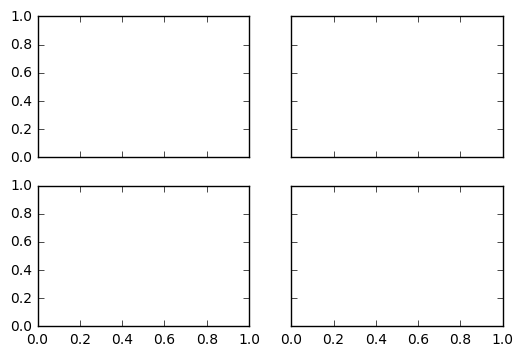

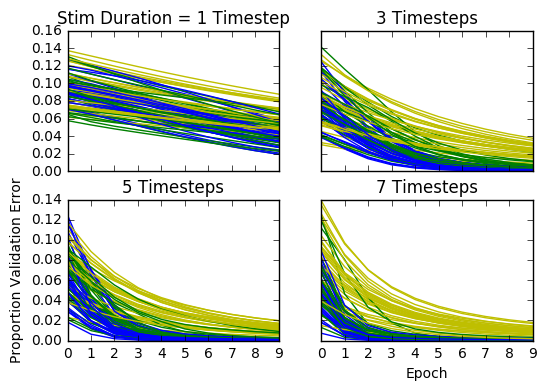

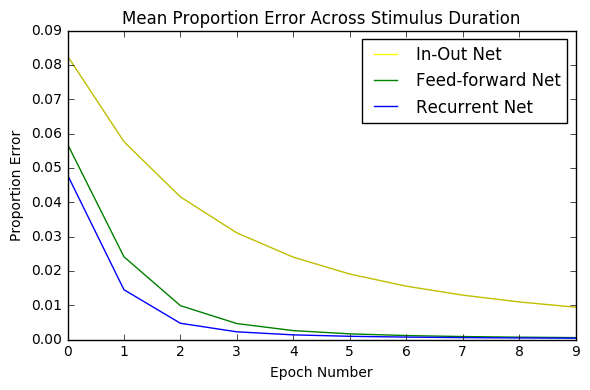

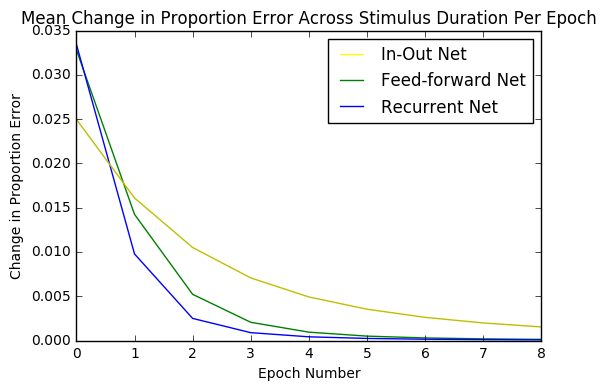

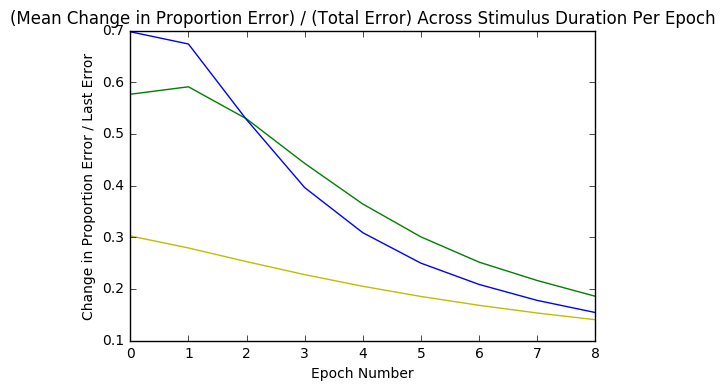

In [22]:
##Then graph learning curves across stimulus durations,
## as well as graphing averaged performance and learning speed

f, ((s1,s2),(s3,s4)) = plt.subplots(2, 2, sharex='col', sharey='row')
s4.set_xlabel('Epoch')
s3.set_ylabel('Proportion Validation Error')

s1.set_title('Stim Duration = 1 Timestep')
s2.set_title('3 Timesteps')
s3.set_title('5 Timesteps')
s4.set_title('7 Timesteps')


for i,j in enumerate(ff_errs[1]):
    s1.plot(ff_errs[1][i], 'g')
    s1.plot(rec_errs[1][i], 'b')
    s1.plot(sim_errs[1][i], 'y')
    
for i,j in enumerate(ff_errs[3]):
    s2.plot(ff_errs[3][i], 'g')
    s2.plot(rec_errs[3][i], 'b')
    s2.plot(sim_errs[3][i], 'y')

for i,j in enumerate(ff_errs[5]):
    s3.plot(ff_errs[5][i], 'g')
    s3.plot(rec_errs[5][i], 'b')
    s3.plot(sim_errs[5][i], 'y')

for i,j in enumerate(ff_errs[7]):
    s4.plot(ff_errs[7][i], 'g')
    s4.plot(rec_errs[7][i], 'b')
    s4.plot(sim_errs[7][i], 'y')
    
plt.show()
ff_means = []
rec_means = []
sim_means = []
ff_changes = []
rec_changes = []
sim_changes = []
ff_n_changes = []
rec_n_changes = []
sim_n_changes = []
for val in s:
    ff_means = elemwise_mean(ff_errs[val])
    rec_means = elemwise_mean(rec_errs[val])
    sim_means = elemwise_mean(sim_errs[val])
    ff_changes = change_per_epoch(ff_means)
    rec_changes = change_per_epoch(rec_means)
    sim_changes = change_per_epoch(sim_means)
    ff_n_changes = change_per_epoch(ff_means, div=True)
    rec_n_changes = change_per_epoch(rec_means, div=True)
    sim_n_changes = change_per_epoch(sim_means, div=True)
    
f2, (m1) = plt.subplots(1, 1)
m1.plot(ff_means, 'g')
m1.plot(rec_means, 'b')
m1.plot(sim_means, 'y')
m1.set_title('Mean Proportion Error Across Stimulus Duration')
m1.set_xlabel('Epoch Number')
m1.set_ylabel('Proportion Error')
    
blu = mlines.Line2D([], [], color='blue', label='Recurrent Net')
gren = mlines.Line2D([], [], color='green', label='Feed-forward Net')
yel = mlines.Line2D([], [], color='yellow', label='In-Out Net')
m1.legend(handles=[yel, gren, blu])

f3, (m2) = plt.subplots(1, 1)

m2.plot(ff_changes, 'g')
m2.plot(rec_changes, 'b')
m2.plot(sim_changes, 'y')
m2.set_title('Mean Change in Proportion Error Across Stimulus Duration Per Epoch')
m2.set_xlabel('Epoch Number')
m2.set_ylabel('Change in Proportion Error')
    
blu = mlines.Line2D([], [], color='blue', label='Recurrent Net')
gren = mlines.Line2D([], [], color='green', label='Feed-forward Net')
yel = mlines.Line2D([], [], color='yellow', label='In-Out Net')
m2.legend(handles=[yel, gren, blu])
f2.tight_layout()

f3, (m3) = plt.subplots(1, 1)

m3.plot(np.array(ff_n_changes), 'g')
m3.plot(np.array(rec_n_changes), 'b')
m3.plot(np.array(sim_n_changes), 'y')
m3.set_title('(Mean Change in Proportion Error) / (Total Error) Across Stimulus Duration Per Epoch')
m3.set_xlabel('Epoch Number')
m3.set_ylabel('Change in Proportion Error / Last Error')
    
blu = mlines.Line2D([], [], color='blue', label='Recurrent Net')
gren = mlines.Line2D([], [], color='green', label='Feed-forward Net')
yel = mlines.Line2D([], [], color='yellow', label='In-Out Net')
m2.legend(handles=[yel, gren, blu])
f2.tight_layout()

plt.savefig('graphs.png', bbox_inches='tight')
plt.show()

### Comparing the 3 Models' Learning Curves With Longer Stimulus Duration Variability

In [23]:
from collections import defaultdict

def test():

    a = 30
    ff_errs = defaultdict(list)
    rec_errs = defaultdict(list)
    sim_errs = defaultdict(list)

    s = [1,6,10,15]

    for j in range(a):
        for i,n in enumerate(s):
            per_stim = n
            epochs = 10
            ff_network, ff_err = train_net(net_type='ff',timesteps_per_stim=per_stim, num_epochs=epochs,train_noise=True,test_noise=True)
            rec_network, rec_err = train_net(net_type='rec',timesteps_per_stim=per_stim, num_epochs=epochs,train_noise=True,test_noise=True)
            sim_network, sim_err = train_net(net_type='s',timesteps_per_stim=per_stim, num_epochs=epochs,train_noise=True,test_noise=True)

            ff_errs[n].append(ff_err)
            rec_errs[n].append(rec_err)
            sim_errs[n].append(sim_err)
            #splots[i].plot(ff_err, 'g')
            #splots[i].plot(rec_err, 'b')

    #for i,n in enumerate(s):
    #    splots[i].set_title('Stimulus Duration = ' + str(n) + 'Timesteps')

    f, ((s1,s2),(s3,s4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    s4.set_xlabel('Epoch')
    s3.set_ylabel('Proportion Validation Error')

    s1.set_title('Stim Duration = '+ str(s[0]) + 'Timestep')
    s2.set_title(str(s[1]) + 'Timesteps')
    s3.set_title(str(s[2]) + ' Timesteps')
    s4.set_title(str(s[3]) + ' Timesteps')


    for i,j in enumerate(ff_errs[1]):
        s1.plot(ff_errs[s[0]][i], 'g')
        s1.plot(rec_errs[s[0]][i], 'b')
        s1.plot(sim_errs[s[0]][i], 'y')

    for i,j in enumerate(ff_errs[s[1]]):
        s2.plot(ff_errs[s[1]][i], 'g')
        s2.plot(rec_errs[s[1]][i], 'b')
        s2.plot(sim_errs[s[1]][i], 'y')

    for i,j in enumerate(ff_errs[s[2]]):
        s3.plot(ff_errs[s[2]][i], 'g')
        s3.plot(rec_errs[s[2]][i], 'b')
        s3.plot(sim_errs[s[2]][i], 'y')

    for i,j in enumerate(ff_errs[s[3]]):
        s4.plot(ff_errs[s[3]][i], 'g')
        s4.plot(rec_errs[s[3]][i], 'b')
        s4.plot(sim_errs[s[3]][i], 'y')

    plt.show()
    plt.savefig('graphs-noise-4.png', bbox_inches='tight')
    ff_means = []
    rec_means = []
    sim_means = []
    ff_changes = []
    rec_changes = []
    sim_changes = []
    ff_n_changes = []
    rec_n_changes = []
    sim_n_changes = []
    for val in s:
        ff_means = elemwise_mean(ff_errs[val])
        rec_means = elemwise_mean(rec_errs[val])
        sim_means = elemwise_mean(sim_errs[val])
        ff_changes = change_per_epoch(ff_means)
        rec_changes = change_per_epoch(rec_means)
        sim_changes = change_per_epoch(sim_means)
        ff_n_changes = change_per_epoch(ff_means, div=True)
        rec_n_changes = change_per_epoch(rec_means, div=True)
        sim_n_changes = change_per_epoch(sim_means, div=True)

    f2, (m1) = plt.subplots(1, 1)
    m1.plot(ff_means, 'g')
    m1.plot(rec_means, 'b')
    m1.plot(sim_means, 'y')
    m1.set_title('Mean Proportion Error Across Stimulus Duration')
    m1.set_xlabel('Epoch Number')
    m1.set_ylabel('Proportion Error')

    blu = mlines.Line2D([], [], color='blue', label='Recurrent Net')
    gren = mlines.Line2D([], [], color='green', label='Feed-forward Net')
    yel = mlines.Line2D([], [], color='yellow', label='In-Out Net')
    m1.legend(handles=[yel, gren, blu])
    
    plt.savefig('graphs-noise-1.png', bbox_inches='tight')

    f3, (m2) = plt.subplots(1, 1)

    m2.plot(ff_changes, 'g')
    m2.plot(rec_changes, 'b')
    m2.plot(sim_changes, 'y')
    m2.set_title('Mean Change in Proportion Error Across Stimulus Duration Per Epoch')
    m2.set_xlabel('Epoch Number')
    m2.set_ylabel('Change in Proportion Error')

    blu = mlines.Line2D([], [], color='blue', label='Recurrent Net')
    gren = mlines.Line2D([], [], color='green', label='Feed-forward Net')
    yel = mlines.Line2D([], [], color='yellow', label='In-Out Net')
    m2.legend(handles=[yel, gren, blu])
    f2.tight_layout()

    plt.savefig('graphs-noise-2.png', bbox_inches='tight')
    
    f3, (m3) = plt.subplots(1, 1)

    m3.plot(np.array(ff_n_changes), 'g')
    m3.plot(np.array(rec_n_changes), 'b')
    m3.plot(np.array(sim_n_changes), 'y')
    m3.set_title('(Mean Change in Proportion Error) / (Total Error) Across Stimulus Duration Per Epoch')
    m3.set_xlabel('Epoch Number')
    m3.set_ylabel('Change in Proportion Error / Total Error')

    blu = mlines.Line2D([], [], color='blue', label='Recurrent Net')
    gren = mlines.Line2D([], [], color='green', label='Feed-forward Net')
    yel = mlines.Line2D([], [], color='yellow', label='In-Out Net')
    m2.legend(handles=[yel, gren, blu])
    f2.tight_layout()

    plt.savefig('graphs-noise-3.png', bbox_inches='tight')
    plt.show()
    
    return ff_errs, rec_errs, sim_errs

Feed forward:
Starting training...
Final results:
  test loss:			0.066556
Recursive:
Starting training...
Final results:
  test loss:			0.064560
Simple in-out:
Starting training...
Final results:
  test loss:			0.069973
Feed forward:
Starting training...
Final results:
  test loss:			0.009590
Recursive:
Starting training...
Final results:
  test loss:			0.011959
Simple in-out:
Starting training...
Final results:
  test loss:			0.018984
Feed forward:
Starting training...
Final results:
  test loss:			0.006200
Recursive:
Starting training...
Final results:
  test loss:			0.007176
Simple in-out:
Starting training...
Final results:
  test loss:			0.011408
Feed forward:
Starting training...
Final results:
  test loss:			0.004079
Recursive:
Starting training...
Final results:
  test loss:			0.005112
Simple in-out:
Starting training...
Final results:
  test loss:			0.006878
Feed forward:
Starting training...
Final results:
  test loss:			0.083474
Recursive:
Starting training...
Final results:

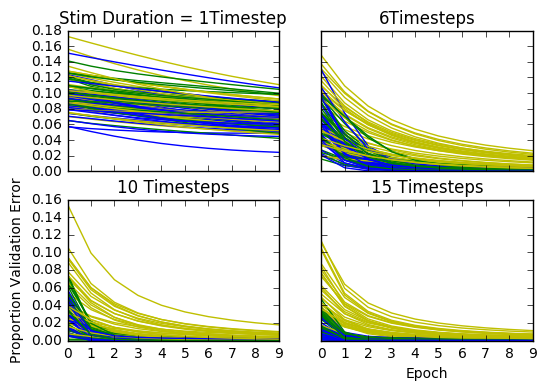

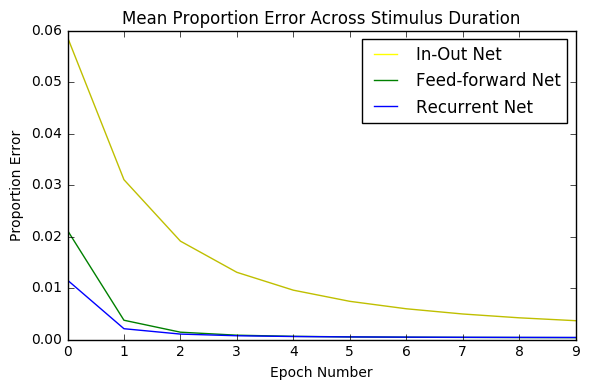

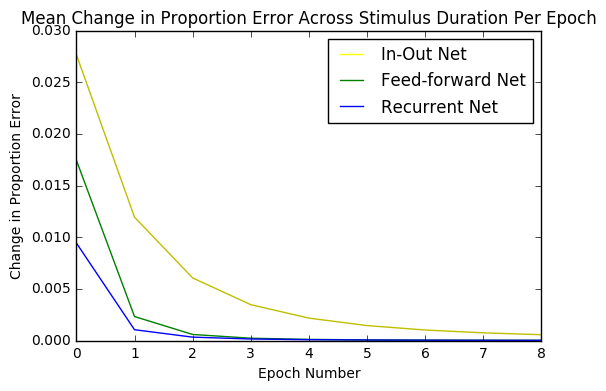

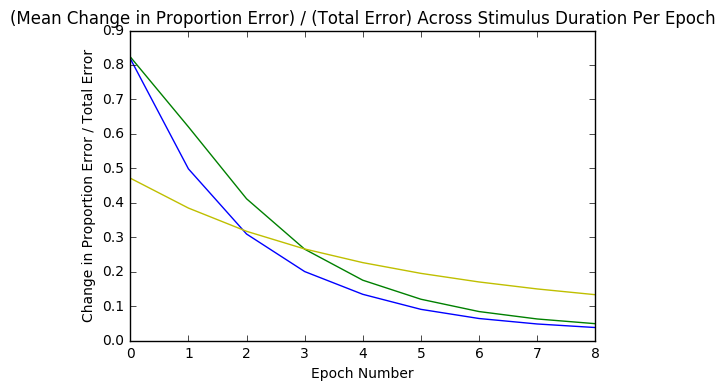

In [24]:
fff,rr,ss = test()

In [ ]:
def get_net_output(the_net):
    input_v = T.tensor4('inputs')
    prediction = lasagne.layers.get_output(the_net, input_v)
    return theano.function([input_v], prediction)

[[ 0.40276143]
 [ 0.37263793]
 [ 0.48576095]
 [ 0.35326902]
 [ 0.42435567]
 [ 0.38747797]
 [ 0.54538834]
 [ 0.61214224]
 [ 0.51873628]
 [ 0.38580285]
 [ 0.59775329]
 [ 0.60242267]
 [ 0.64017333]
 [ 0.57093654]
 [ 0.6631038 ]]
[[ 0.48689171]
 [ 0.47792859]
 [ 0.48161301]
 [ 0.48923598]
 [ 0.48655782]
 [ 0.49281081]
 [ 0.49818046]
 [ 0.4981415 ]
 [ 0.50367385]
 [ 0.50751176]
 [ 0.50835147]
 [ 0.51431662]
 [ 0.51238607]
 [ 0.51085318]
 [ 0.51536772]]


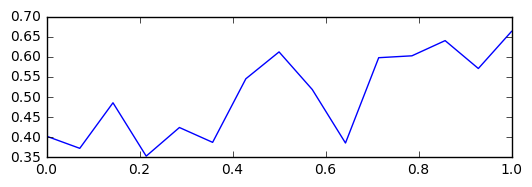

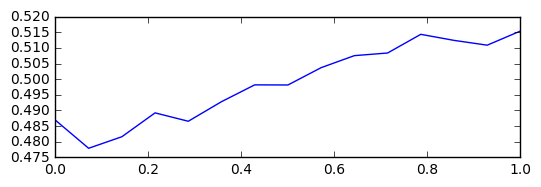

In [29]:
num_categories = 15
X_testo = np.zeros((15,1,1,15))
y_testo = np.zeros((15))
for i in range(15):
        r = 15
        X_testo[i,0,0,i] = 1
        y_testo[i] = (1.0/(num_categories-1))*i


input_theano_var = T.tensor4('inputs')
ff_pred = lasagne.layers.get_output(ff_network, input_theano_var)
get_ff_pred = theano.function([input_theano_var], ff_pred)
#print(X_train[1].reshape((1,1,1,15)))
print(get_ff_pred(X_testo))

r_input_theano_var = T.tensor4('inputs')
r_pred = lasagne.layers.get_output(rec_network, r_input_theano_var)
get_r_pred = theano.function([r_input_theano_var], r_pred)
#print(X_train[1].reshape((1,1,1,15)))
print(get_r_pred(X_testo))
#print(y_testo)
'''
for j in range(a):
    for i,n in enumerate(s):
        per_stim = n
        epochs = 2
        ff_network, ff_err = train_net(net_type='ff',timesteps_per_stim=per_stim, num_epochs=epochs)
        rec_network, rec_err = train_net(net_type='rec',timesteps_per_stim=per_stim, num_epochs=epochs)
        sim_network, sim_err = train_net(net_type='s',timesteps_per_stim=per_stim, num_epochs=epochs)
'''
test_res = get_ff_pred(X_testo).reshape(15)
t1 = y_testo
plt.figure(1)
plt.subplot(211)
plt.plot(t1, get_ff_pred(X_testo).reshape(15))
plt.show()

test_res = get_r_pred(X_testo).reshape(15)
t1 = y_testo
plt.figure(1)
plt.subplot(212)
plt.plot(t1, get_r_pred(X_testo).reshape(15))
plt.show()

In [ ]:
ex = np.zeros((1,1,1,15))
ex[0,0,0,1] = 1
input_var = ex

lasagne.layers.get_output(network)

In [ ]:
np.random.normal(loc=0,scale=.05,size=(1,1,1,num_categories))

In [ ]:
X_train[1]

In [ ]:
np.abs([1,2,-33])